In [1]:
current<-getwd()
setwd("/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Donor4Donor9")
source("activate.R")
Sys.setenv(RENV_PATHS_CACHE = "/lab/solexa_weissman/cweng/Packages/R/x86_64-pc-linux-gnu-library/4.1-focal") 
renv::paths$cache()
# .libPaths(c(renv::paths$cache(),.libPaths()))
.libPaths()
setwd(current)

[1] "/lab/solexa_weissman/cweng/Packages/R/x86_64-pc-linux-gnu-library/4.1-focal/v5/R-4.1/x86_64-pc-linux-gnu"

[1] "/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Donor4Donor9/renv/library/R-4.1/x86_64-pc-linux-gnu"
[2] "/tmp/RtmpaxMTKL/renv-system-library"

# Introduction

ReDeeM (single-cell Regulatory multi-omics with Deep Mitochondrial mutation profiling) is an engineering-free single cell sequencing technology for somatic mutation-based retrospective lineage tracing, clonal/subclonal mapping, with simultaneous cell-state profiling (transcriptomics and chromatin accessibility).
    
In this tutorial, we will be analyzing a ReDeeM datasets of human hematopoietic stem and progenitor cells. This tutorial will cover most basic analysis to get started with ReDeeM. The basic analysis includes:
- <a href=#S4>How to setup redeemR object </a> 
- <a href=#S5>What's the mtDNA capture efficiency, detected mutation number, etc </a> 
- <a href=#S6>Validation of consensus mtDNA mutation detection </a> 
- <a href=#S7>Generate Cell vs mutation matrix </a> 
- <a href=#S8>Clonal distance and clonal clustering </a> 
- <a href=#S9>Single cell phylogenetic tree analysis </a> 
- <a href=#S10>Assign mutations onto tree </a> 
- <a href=#S11>Link sc-multiome(GEX+ATAC) data </a> 

# Example data

# Installation

In [ ]:
RedeemR

In [2]:
# devtools::install_github("chenweng1991/redeemR")
# library(redeemR)

In [2]:
install.packages("/lab/solexa_weissman/cweng/Packages/redeemR/")

Installing redeemR [1.0] ...
	OK [built from source]


# Setup redeemR object<a name='S4' />

We first load the data that were preprocessed by [redeemV](https://github.com/chenweng1991/redeemV). A typical result folder after redeemV should at least includes the following files to enable [redeemR](https://github.com/chenweng1991/redeemR):
```bash
├── QualifiedTotalCts
├── RawGenotypes.Sensitive.StrandBalance
├── RawGenotypes.Specific.StrandBalance
├── RawGenotypes.Total.StrandBalance
└── RawGenotypes.VerySensitive.StrandBalance
```

By default, redeemV provides results with four stringency:
- Total, or Toral (**T**), without consensus filtering
- VerySensisitve, or less stringent (**LS**) consensus filtering
- Sensitive, or stringent (**S**) consensus filtering, <font color='red'>recommended</font>
- Specific, or Very stringent (**VS**) consensus filtering

**QualifiedTotalCts** stores the information of mtDNA coverage per position per cell<br>
**RawGenotypes.*.StrandBalance** stores the genotype information and consensus levels, etc

For detailed explanation of these 4 stringency, please check Github WiKi<br>
For detailed data structure of each file, please check Github WiKi

We will load the data using ***redeemR.read(path,thr,Processed)***
- path: The redeemV result folder path
- thr: Consensus level, one of T, LS, S, VS
- Processed: if run initially, set Processed=F, which will load and process the raw data and save as VariantsGTSummary.RDS into path. if not run initially, set Processed=T to save time which will directly read from VariantsGTSummary.RDS

In [3]:
Dir="/lab/solexa_weissman/cweng/Sharing/ReDeeM_Tutorial/ReDeeM_Example_Data"

In [4]:
library(redeemR)
VariantsGTSummary<-redeemR.read(path=Dir,thr="S",Processed=T)

> VariantsGTSummary is a dataframe with each row the record of a mtDNA mutation in a given cell. It stores the key information including Cell barcode(Cell), Position_ref_alt(Variants), Number of mutant allele(Freq), Number of total captured allele number(depth), mutation type(type), Mutation context(Context), Heteroplasmy(hetero). See below.

In [5]:
head(VariantsGTSummary,n=3)

,Var1,Cell,Variants,Freq,depth,Type,Context,hetero
,<fct>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>
1,AAACAAGCACCTCGAC_10626_T_G,AAACAAGCACCTCGAC,10626_T_G,8,26,T_G,CTC,0.30769231
2,AAACAAGCACCTCGAC_11164_A_T,AAACAAGCACCTCGAC,11164_A_T,1,35,A_T,CTA,0.02857143
3,AAACAAGCACCTCGAC_11545_T_A,AAACAAGCACCTCGAC,11545_T_A,1,37,T_A,TTG,0.02702703


Next, Run ***Create_redeemR(VariantsGTSummary)*** to create redeemR object<br>
The object serves as a container that contains both data (like the mutation genotype) and analysis (like clonal distance or phylogenetic results) for a ReDeeM dataset.<br>
For detailed explanation of redeemR data slots, please check Github WiKi

***Create_redeemR*** takes VariantsGTSummary as input and perform mtDNA mutation refinement. 
For more details of the parameter for mutation refinement please check Github WiKi

In [4]:
Example_redeemR<-Create_redeemR(VariantsGTSummary) # This is using default parameter
# The full statement is Example_redeemR<-Create_redeemR(VariantsGTSummary,qualifiedCellCut=10,VAFcut=1,Cellcut=2,maxctscut=2)

[1] "41834 variants to start"
[1] "41735 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 11674_C_T" "Tag Homoplasmy: 11719_G_A"
 [3] "Tag Homoplasmy: 11947_A_G" "Tag Homoplasmy: 12414_T_C"
 [5] "Tag Homoplasmy: 1243_T_C"  "Tag Homoplasmy: 12705_C_T"
 [7] "Tag Homoplasmy: 12923_G_T" "Tag Homoplasmy: 1406_T_C" 
 [9] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 14766_C_T"
[11] "Tag Homoplasmy: 15326_A_G" "Tag Homoplasmy: 15884_G_C"
[13] "Tag Homoplasmy: 16223_C_T" "Tag Homoplasmy: 16292_C_T"
[15] "Tag Homoplasmy: 16519_T_C" "Tag Homoplasmy: 194_C_T"  
[17] "Tag Homoplasmy: 195_T_C"   "Tag Homoplasmy: 199_T_C"  
[19] "Tag Homoplasmy: 204_T_C"   "Tag Homoplasmy: 207_G_A"  
[21] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 2706_A_G" 
[23] "Tag Homoplasmy: 3505_A_G"  "Tag Homoplasmy: 4769_A_G" 
[25] "Tag Homoplasmy: 5046_G_A"  "Tag Homoplasmy: 5460_G_A" 
[27] "Tag Homoplasmy: 7028_C_T"  "Tag Homoplasmy: 7058_T_C" 
[29] "Tag Homoplasmy: 709_G_A"   "Tag Homoplasmy: 73_A_G"   
[31

> The redeemR object **Example_redeemR** has been generated 
> - Filtered genotype info is stored in Slot: <u>GTsummary.filtered</u> where each row is a mutation in a given cell
> - Filtered genotype feature info are stored in Slot: <u>V.fitered</u> where each row is a mutation across all cells

In [8]:
head(Example_redeemR@GTsummary.filtered,n=2)
head(Example_redeemR@V.fitered,n=2)

,Var1,Cell,Variants,Freq,depth,Type,Context,hetero
,<fct>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>
1,AAACAAGCACCTCGAC_10626_T_G,AAACAAGCACCTCGAC,10626_T_G,8,26,T_G,CTC,0.30769231
2,AAACAAGCACCTCGAC_11164_A_T,AAACAAGCACCTCGAC,11164_A_T,1,35,A_T,CTA,0.02857143


,Variants,CellN,PositiveMean,maxcts,CellNPCT,TotalVcount,TotalCov,totalVAF,CV,HomoTag
,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
6,1000_T_C,9,0.0328861,8,0.0014153169,22,451310,4.874698e-05,0.008177771,Hetero
11,10001_T_C,3,0.0705272,12,0.0004717723,14,385839,3.628456e-05,0.122017337,Hetero


In [7]:
Example_redeemR ## Run this will print out the essential information.

Warning message:
“Unknown or uninitialised column: `Label`.”


        Threhold qualifiedCellCut           VAFcut          Cellcut 
             "S"             "10"              "1"              "2" 
       maxctscut 
             "2" 
      AllCellN QualifiedCellN 
          7404           6359 
            VN_total VN_rmvLowQualityCell            VN_filter 
               41834                41735                 4837 
   VN_filter_rmvHomo 
                4803 
< table of extent 0 >
[1] "Total Variant number: 4837"
[1] "Including Homoplasmy Variant number: 34"
 [1] "Slot: GTsummary.filtered" "Slot: CellMeta"          
 [3] "Slot: V.fitered"          "Slot: UniqueV"           
 [5] "Slot: DepthSummary"       "Slot: HomoVariants"      
 [7] "Slot: Cts.Mtx"            "Slot: Cts.Mtx.bi"        
 [9] "Slot: Ctx.Mtx.depth"      "Slot: para"              
[11] "Slot: Seurat"             "Slot: DataToplotList"    
[13] "Slot: DistObjects"        "Slot: TREE"              
[15] "Slot: AssignedVariant"    "Slot: attr"              
[1] "The original p

> Above print out essential information in redeemR object:
> - parameters used for filtering (Threhold, qualifiedCellCut, OnlyHetero, VAFcut, Cellcut, maxctscut)
> - Cell filtering records: **AllCellN** is total cell numbers, **QualifiedCellN** is the cell numbers with good mtDNA coverage.
> - Variant filtering records: **VN_total** is the total variant number, **VN_rmvLowQualityCell** is the number of variants on qualified cells.**VN_filter** is the number of variants after filtering. **VN_filter_rmvHomo** is the number of variants after removing homoplasmic mutations. 
> - Summary of cells from different label, if label is available in Slot: CellMeta
> - All slots names

# Quality control of redeemR<a name='S5'/>

We will then investigate several basic aspects of the redeemR data, which is stored in the redeemR object and can be visulized by our functions. The aspects includes:
- mtDNA coverage in each cell
- mtDNA mutation signature
- mtDNA mutation abundance and frequency

First, run ***plot_depth(Example_redeemR)*** to show mtDNA coverage

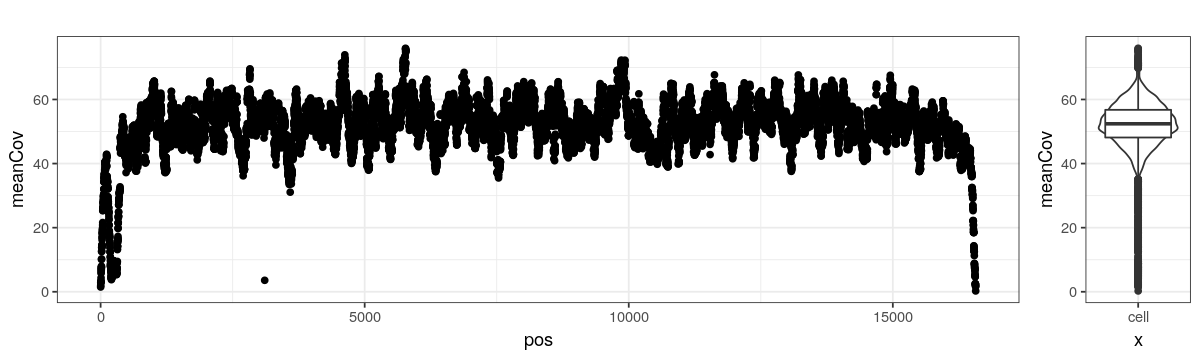

In [6]:
plot_depth(Example_redeemR)

> - The left panel shows the averaged (for all single cells) mtDNA coverage(unique fragment number) in each position(1-16569) along x axis
> - The right panel shows the distribution of all single cells of averaged (for all positions) mtDNA coverage 

Next, run ***MutationProfile.bulk*** to show mtDNA mutation signatures

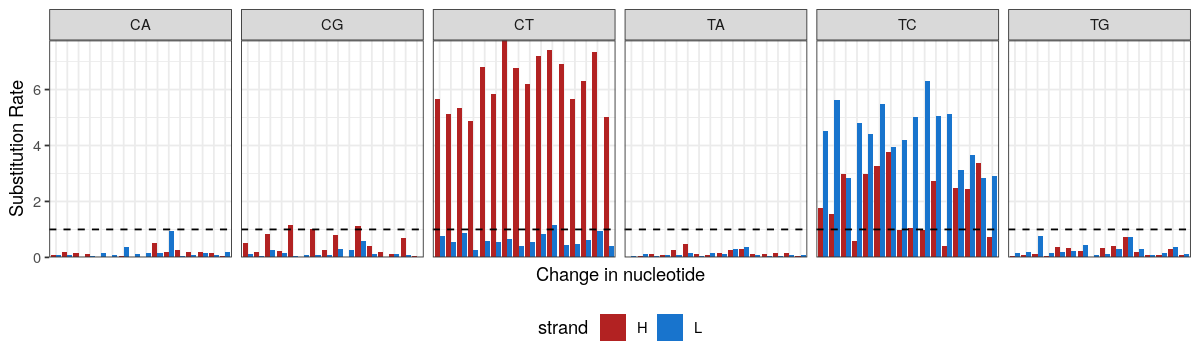

In [7]:
MutationProfile.bulk(Example_redeemR@UniqueV)

> After filtering, qualified mutations are stored in Example_redeemR@UniqueV
> Above shows the mutation signatures in each class of mononucleotide and trinucleotide change by the heavy (H) and light (L) strands. 

Last, run ***plot_variant(Example_redeemR)*** to show mtDNA mutation metrics

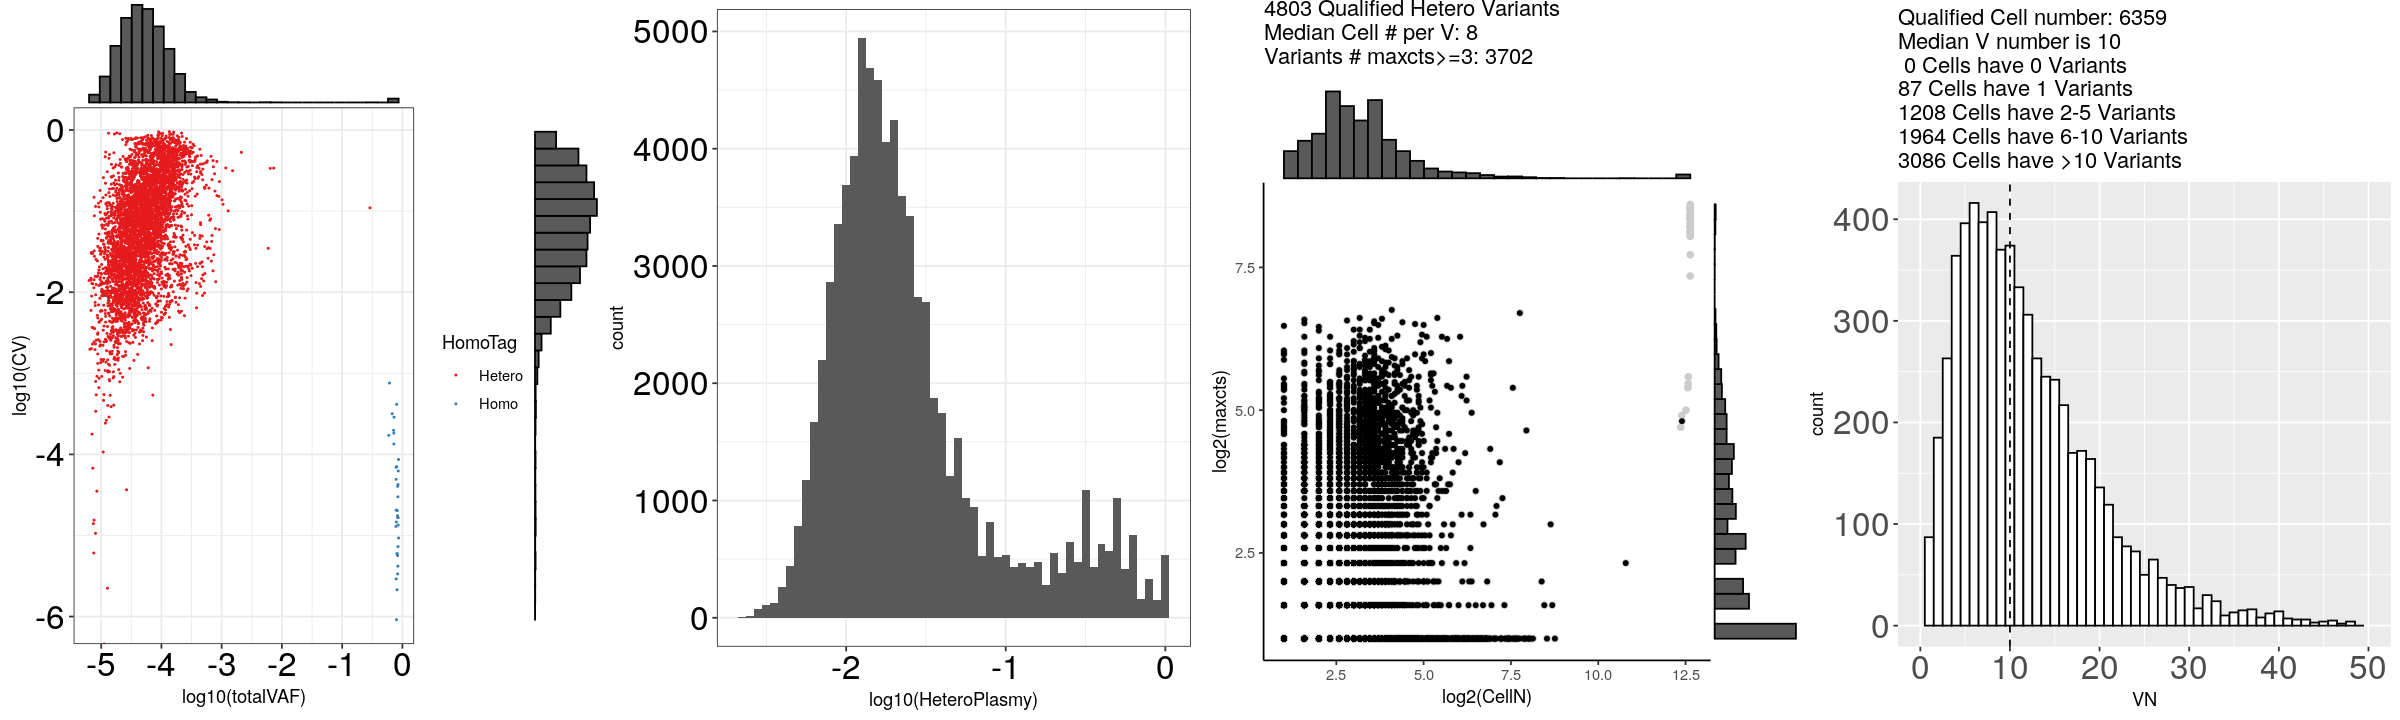

In [9]:
plot_variant(Example_redeemR)

> The above 4 panels describes metrics of mtDNA mutations
> - First panel shows the total variant allele frequency(totalVAF, # of variant allele/ # of all alleles in all cells) against Coefficiency of Variance(CV)
> - Second panel shows the distribution of log10 heteroplasmy in single cells
> - Third panel shows the number of cells that carry a mutation against the max number of variant allele in any cell
> - Last panel shows the number of variants carried by a given cell.

# Consensus mtDNA mutation benchmark<a name='S6' />

> The performance of consensus mutation detection can be examined using ***Show_Consensus(Example_redeemR)***<br>
> It will first print out three metrics:
> - The distribution of UMI family sizes
> - The distribution of consensus scores
> - A percentage of mutations validated by both R1 and R2 in sequencing.<br>

> ***Show_Consensus*** also randomly plot 25 mutations as examples to show the exact metrics including UMI size, censusens score, R1/R2 overlap percentage, and strand biases.

Using Call as id variables



[1] "Quantile of UMI family size"
  0%  25%  50%  75% 100% 
   2    3    5    8  105 
[1] "Quantile of consensus score"
       0%       25%       50%       75%      100% 
0.7575758 1.0000000 1.0000000 1.0000000 1.0000000 
[1] "Percentage of R1/R2 overlaped mutation detections"
[1] 0.9332611


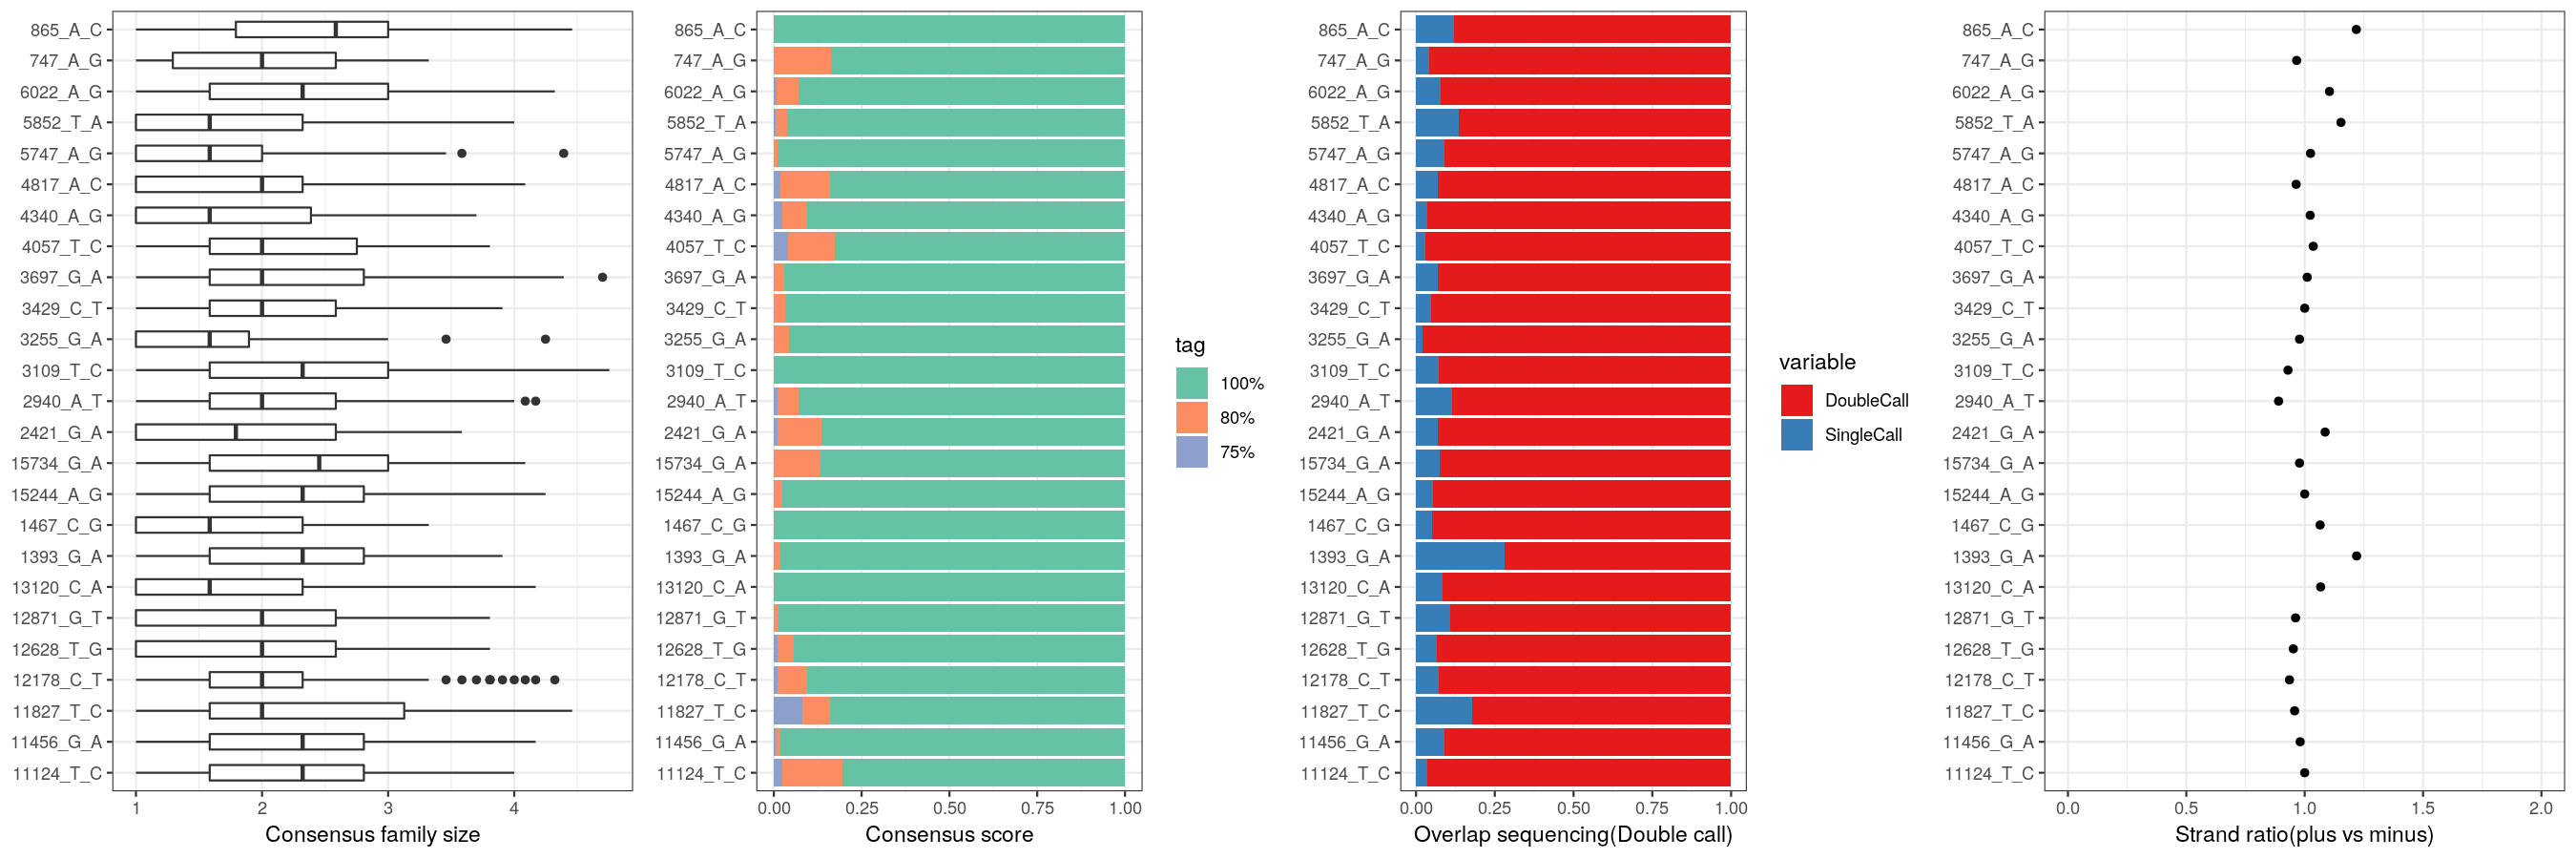

In [8]:
Show_Consensus(Example_redeemR)

Since different experimental batch, different cells may have different UMI family size and consensus score due to technical reason, we compute *RejectRate* for normalization that removes technical biases in downstream analysis.<br>
*RejectRate* is defined as the remaining percentage after consensus filtering.

In [7]:
Example_redeemR<-ComputeRejectRate(Example_redeemR)

RejectRate has been added to @CellMeta



# Cell vs. Mutation matrix<a name='S7' />

Next, we will run ***Make_matrix(Example_redeemR,onlyhetero=T)*** to generte the sparse matries of cell vs mtDNA mutation, from which cell-cell clonal distances, etc will be estimated later.<br>
By default, only heteroplasmic mutations are considered into the matrix, becasue homoplasmic mutations do not provide clonal relationship information.
Note, two sparse matries will be generated:
- @Cts.Mtx is the count matrix that stores the number of mutant alleles in any given cell
- @Cts.Mtx.bi is binarized matrix that store 0 or 1.


In [6]:
Example_redeemR<-Make_matrix(Example_redeemR,onlyhetero=T)

Only heteroplasmic mutations are used

@Cts.Mtx and @Cts.Mtx.bi are added



In [7]:
Example_redeemR@Cts.Mtx[1:3,1:3]

3 x 3 sparse Matrix of class "dgCMatrix"
                 Variants1000TC Variants10001TC Variants10002AC
AAACAAGCACCTCGAC              .               .               .
AAACCAGGTAACGAGC              .               .               .
AAACCAGGTGCAACGG              .               .               .

> @Cts.Mtx and @Cts.Mtx.bi are stored as sparse matrix dgCMatrix

# Clonal distance and clustering<a name='S8' />

Next, we will infer the cell to cell relationships by computing mtDNA somatic mutation based distances.<br>
We reasoned that the mutant allele count in @Cts.Mtx is vulnerable to depth biases and thus a binarized distance is used first, although mutant count is potentially informative.<br> 
Therefore, here we start with binarized matrix @Cts.Mtx.bi<br>
We provide multiple binary distances using our method ***SeuratLSIClustering*** and ***AddDist***, which includes:
- weighted Jaccard (w_jaccard)
- Latent Semantic Indexing (LSI) 
- jaccard
- dice
- jaccard3W
- weighted Cosine (w_cosine)
Other alternative distances could be used in ***BinaryDist***, such as "Simpson","Kulczynski2","Ochiai","Hamming"

LSI based distance is also a good option for binary matrix, which uses TF-IDF for normalization followed by SVD for dimension reduction. We wrapped Seurat and Signac functions such as RunTFIDF,RunUMAP, etc for mtDNA mutation LSI analysis<br>
Here we will run ***SeuratLSIClustering*** to implement LSI, which will create an Seurat object @Seurat with the assay "redeemR" 

In [8]:
Example_redeemR<-suppressMessages(SeuratLSIClustering(Example_redeemR,lsidim=2:50))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6317
Number of edges: 294992

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9461
Number of communities: 51
Elapsed time: 0 seconds


After running above, we can check the global clonal types based on LSI clustering

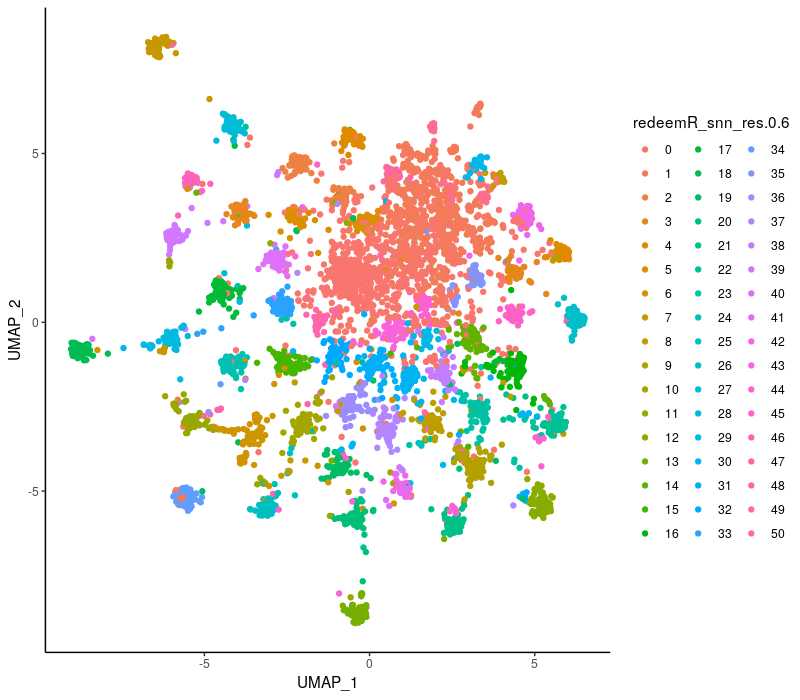

In [10]:
library(ggplot2)
library(dplyr)
options(repr.plot.width=8, repr.plot.height=7,repr.plot.res=100)
Tomerge_v2(Example_redeemR@Seurat@meta.data,Example_redeemR@Seurat@reductions$umap@cell.embeddings) %>% ggplot()+aes(UMAP_1, UMAP_2,color=redeemR_snn_res.0.6)+geom_point()+theme_classic()

> Above is a UMAP based on mtDNA mutation derived LSI space

For weighted distances (w_jaccard, w_cosine), a prior will be given to weight each mutation to account for in-parallele evolution (i.e, mutation arise by chance in two cells independently instead of by inheritance).<br>
The prior can be estimated according to the population-based recurrency. We provide a prior for human bone marrow Experiments. Different tissue may have different prior. If a prior is not available, a flat distance can also be applied.

In [11]:
##(Optional) Prepare prior for human bone marrow experiments, if a weighted distance is applied later
data(CellPCT)
V.weight<-data.frame(weight=1-CellPCT$muRate)
V.weight$Variants<-paste("Variants",gsub("_","",CellPCT$Variant),sep="")

Run ***AddDist(Example_redeemR,weightDF=V.weight)*** that will add distances into *@DistObjects*

In [12]:
Example_redeemR<-AddDist(Example_redeemR,weightDF=V.weight, LSIdist=T) # if LSIdist=T, SeuratLSIClustering needs to be run before. 

[1] "Weight vector matches well with the Cell-Variant matrix, continue..."


jaccard distances added

dice distances added

3wjaccard distances added

weighted jaccard distances added

weighted cosine distances added

LSI distances added



Next, with the distance computed, we will generate the mutual k-nearest neighbor (MNN) cell-cell network based on mtDNA mutation similarity or distance.
We will run ***FromDist2Graph*** which will generate an [igraph](https://igraph.org/r/) object for network analysis. [More for igraph](https://kateto.net/netscix2016.html)

In [49]:
Example_redeemR.mnn.igraph<-FromDist2Graph(Example_redeemR@DistObjects@w_jaccard)  # The input can be other distances as well

In [50]:
Example_redeemR.mnn.igraph

IGRAPH cf6a3af UN-- 6345 39219 -- 
+ attr: name (v/c)
+ edges from cf6a3af (vertex names):
 [1] AAACAAGCACCTCGAC--ACGCACGCAACAACAT AAACAAGCACCTCGAC--CATAACCGTTGAGTCT
 [3] AAACAAGCACCTCGAC--CCTAATAGTCAATTCA AAACAAGCACCTCGAC--CTTTGTGAGGATTGGT
 [5] AAACAAGCACCTCGAC--GAATGACTCCTAAGCC AAACAAGCACCTCGAC--GTTTGGTGTTTGAGCT
 [7] AAACAAGCACCTCGAC--TTTCCTGGTGCAGTAA AAACCAGGTAACGAGC--AAACTCGCAGGCAACT
 [9] AAACCAGGTAACGAGC--ACACCGTTCCAATATC AAACCAGGTAACGAGC--AGGAGGTAGTTGTCAT
[11] AAACCAGGTAACGAGC--AGGGTTAGTTGACCGC AAACCAGGTAACGAGC--AGTTACGCAGGTAAGG
[13] AAACCAGGTAACGAGC--ATCGCCTAGCATCCTA AAACCAGGTAACGAGC--ATGGCTTGTGCCTTTC
[15] AAACCAGGTAACGAGC--ATGTTCCCACATGCAA AAACCAGGTAACGAGC--ATTTACGGTTCCTCAC
+ ... omitted several edges

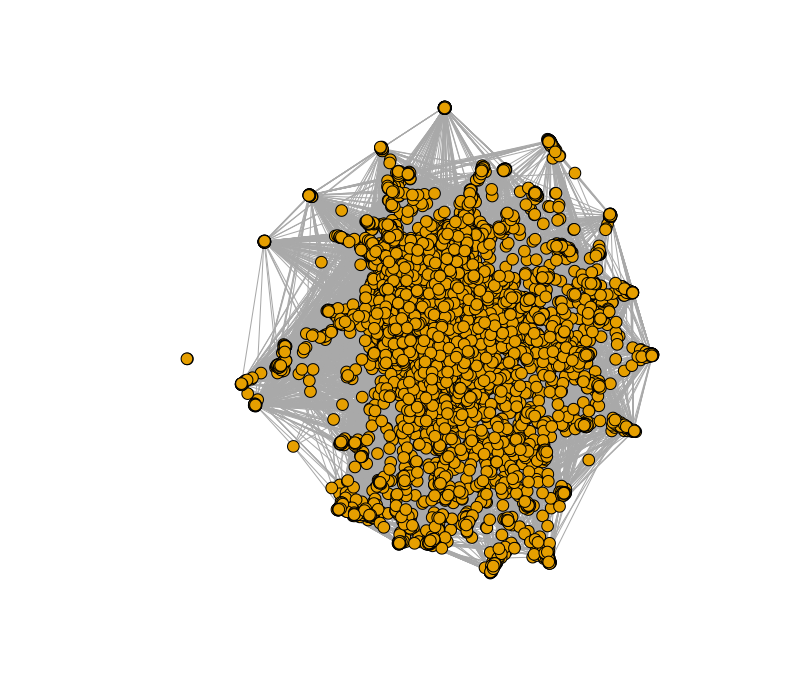

In [51]:
plot(Example_redeemR.mnn.igraph,vertex.size = 5,vertex.label = NA, edge.label = NA) 

Alternatively we could run ***MakeNN*** and ***NN2M*** that computes KNN neighborhoods

In [54]:
Example_redeemR.nn<-MakeNN(Example_redeemR@DistObjects@w_jaccard)
Example_redeemR.knn.matrix<-NN2M(Example_redeemR.nn)
Example_redeemR.knn.igraph<-igraph::graph_from_adjacency_matrix(Example_redeemR.knn.matrix,diag = F,mode = "undirected")

In [36]:
head(Example_redeemR.nn$idx,n=2)
head(Example_redeemR.nn$dist,n=2)

1,1745,3174,2743,2134,4803,1663,983,53,1724,619,3044,5515,5509,3295
2,1345,5649,438,3276,3523,26,5356,2268,3147,1247,3384,938,2356,1482


0,0.8992343,0.9005608,0.9077387,0.9082138,0.9082252,0.9128423,0.9143635,0.9143971,0.9144201,0.9144299,0.9145608,0.9145701,0.9146633,0.9176983
0,0.5393079,0.7617534,0.7737929,0.7810095,0.7810164,0.7813329,0.7894288,0.8006445,0.8021695,0.8039806,0.8058315,0.8119027,0.8127219,0.8134679


> Above show nn, which includes two dataframe:
> - The first dataframe: Each row is a cell, the cell names corresponds to row or column names in distance. Here shows 15 columns that show index of the nearest 15 neighbours 
> - The second dataframe: Each row is a cell, the cell names corresponds to row or column names in distance. Here shows 15 columns that show distances of the nearest 15 neighbours 

# Single cell Phylognetic tree analysis<a name='S9' />

With all the cell-cell distances computed. Next, we implement the neighbor joining algorithm to build the phylogenetic tree.<br>
The reconstructed tree is stored in @TREE
We will run ***Make_tree*** to build the phylogenetic tree 

In [ ]:
Example_redeemR<-Make_tree(Example_redeemR,d = "w_jaccard",algorithm = "nj") # This step may take several to 10 minutes, save out Example_redeemR after this step is recommended

In [6]:
# saveRDS(Example_redeemR,paste(Dir,"/Example_redeemR",sep=""))
Example_redeemR<-readRDS(paste(Dir,"/Example_redeemR",sep=""))

To visulize the tree:

In [8]:
library(ggtree)
library(ggtreeExtra)
library(ggplot2)

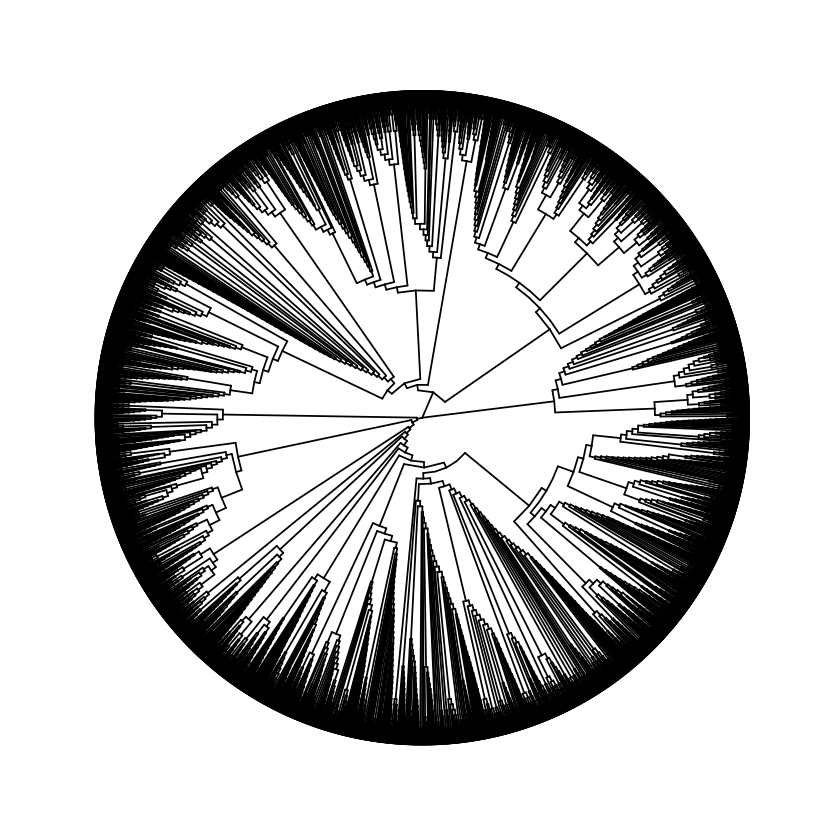

In [10]:
treeplot<-ggtree(Example_redeemR@TREE@treedata,layout="circular", branch.length='none') 
print(treeplot)

Next, update the `@CellMeta` by adding VN(variant number) of mitochondrial mutations and TreePos(cell position on the tree). <br>
Potentially all those information can be displayed on the tree.

In [11]:
library(Matrix)
library(dplyr)
CellTreePos<-subset(treeplot$data,isTip==TRUE) %>% .[order(.$y),] %>% .[,c("label","node","y")] %>% rename(Cell=label,node=node,TreePos=y) # This extract the position of cells on the tree. This order information will be stored in the factor of cells
VN.summary<-data.frame(VN=rowSums(Example_redeemR@Cts.Mtx.bi)) %>% tibble::rownames_to_column("Cell") %>% merge(.,CellTreePos) # This summarize the mtDNA mutations per cell
if(!"TreePos" %in% colnames(Example_redeemR@CellMeta)){
Example_redeemR@CellMeta<-merge(Example_redeemR@CellMeta,VN.summary)
}    

In [12]:
head(Example_redeemR@CellMeta,n=2)

,Cell,meanCov,VN,node,TreePos
,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,AAACAAGCACCTCGAC,47.40672,12,1,2435
2,AAACCAGGTAACGAGC,51.04997,10,2,1667


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“position_stackx requires non-overlapping x intervals”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


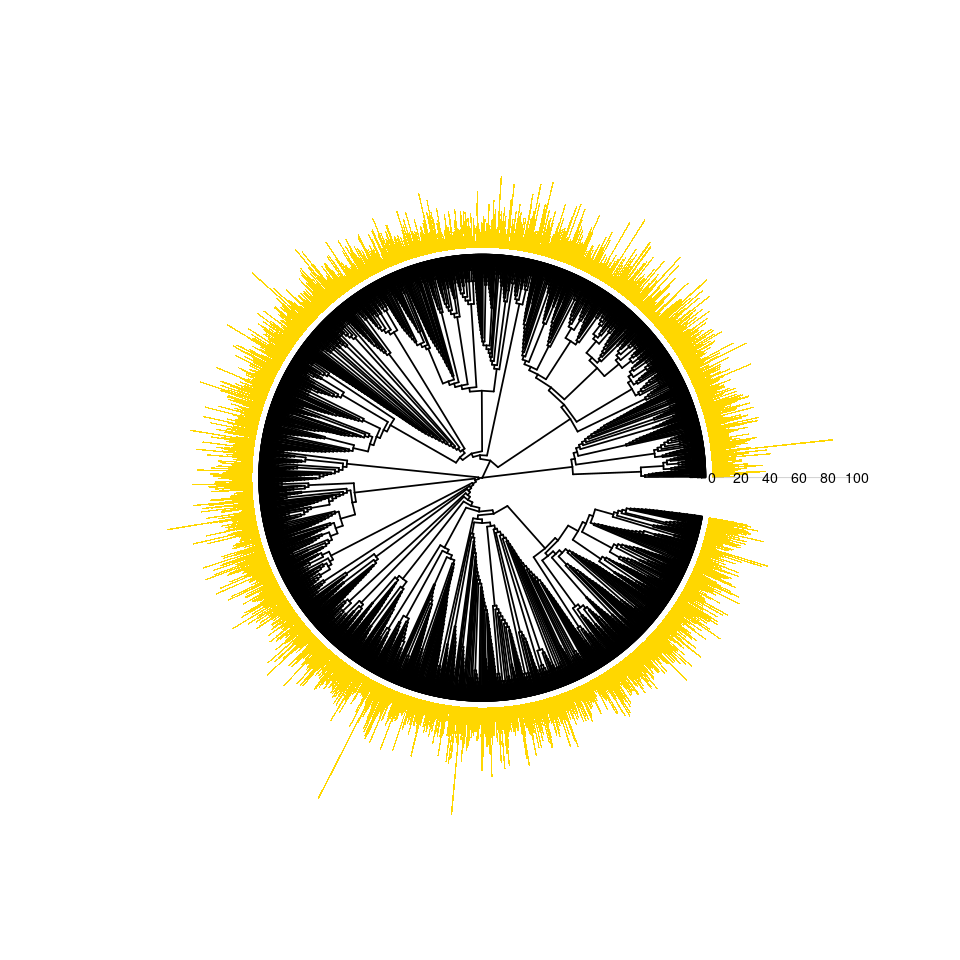

In [45]:
options(repr.plot.width=8, repr.plot.height=8,repr.plot.res=120)
ggtree(Example_redeemR@TREE@treedata,branch.length='none',layout="fan",open.angle = 10)+
geom_fruit(data=Example_redeemR@CellMeta,mapping=aes(y=Cell,
                                           x=VN),
                                           orientation="y",
                                           stat="identity",axis.params=list(axis="x",text.size=3),
                                           geom=geom_bar,pwidth=0.65,width=5,fill="gold")

# Assign mutations onto tree (Optional) <a name='S10' />

Next, the mtDNA mutations were assigned to the tree branches using a maximum likelihood method as described [previously](https://www.nature.com/articles/s41586-021-04312-6). To do that we will run ***Add_DepthMatrix*** and ***Add_AssignVariant***

In [10]:
Example_redeemR<-Add_DepthMatrix(Example_redeemR)  # Need to run Add_DepthMatrix before Add_AssignVariant, which generte a matrix of mtDNA coverage in each mutation site in each single cell for normalization

Remember to update for combined object

Using S as value column: use value.var to override.



After the step above, a matrix of mtDNA coverage in each mutation site in each single cell is stored `@Ctx.Mtx.depth`

In [12]:
head(Example_redeemR@Ctx.Mtx.depth,n=2)

,Variants1000TC,Variants10001TC,Variants10002AC,Variants10013CA,Variants10014GA,Variants10018AG,Variants10026TC,Variants10028AG,Variants10034TC,Variants1004GA,⋯,Variants9979GA,Variants9984GA,Variants9985GA,Variants9987TC,Variants9988CA,Variants9991AG,Variants9993TC,Variants9996TC,Variants9997TC,Variants9998TC
AAACAAGCACCTCGAC,45,39,39,35,35,35,39,39,39,43,⋯,38,37,35,34,34,34,35,33,33,33
AAACCAGGTAACGAGC,63,48,47,47,48,47,51,53,51,65,⋯,47,43,43,45,45,44,44,44,43,42


In [14]:
Example_redeemR<-Add_AssignVariant(Example_redeemR,n.cores=16) ## This step takes a couple of hours depending on how many cores to use

Loading required package: foreach

Loading required package: doMC

Loading required package: iterators

Loading required package: parallel

Loading required package: pryr



[1] "(use doMC)Will gc in each loop; Befrore going into the loop, the memory use is:"
5.48 GB
[1] "The foreach loop is completed, the memory use is"


In [6]:
# Recomend to save out the Example_redeemR at this point
# saveRDS(Example_redeemR,paste(Dir,"/Example_redeemR",sep=""))
# Example_redeemR<-readRDS(paste(Dir,"/Example_redeemR",sep=""))

After running ***Add_AssignVariant***, The assignment is stored `@AssignedVariant`.<br>
In `@AssignedVariant$p` For each variant, the probability of all clades assignments are given. <br>
In `@AssignedVariant$Variant.assign.report` For each variant, the clade with maximum probability is finally assigned. The probability is shown as well. 

In [25]:
Example_redeemR@AssignedVariant$Variant.assign.report %>% head(n=50)  # For example

ERROR: Error in Example_redeemR@AssignedVariant$Variant.assign.report %>% head(n = 50): could not find function "%>%"


> Edge.Assign is defined as the clade((i.e. the full set of cells that descend from a common ancestor and thus encompass branch of a phylogenetic tree) that a given variant is mostly likely assigned to with the given probability(prob).<br>
> Here, Edge.Assign shows the clade ID

To show the cells included in a clade given ID, use ***ShowClade***

In [33]:
ShowClade(Example_redeemR,cladeID = c(6640)) %>% lapply(.,head) # cladeID can be a vector of clades.

[[1]]
[1] "AAACCAGGTGCAACGG" "AACAACATCTTTAGGT" "AACATGATCGCTTCAA" "AACGATTCAGCAAGCT"
[5] "AAGCGCTCATAACGAT" "AAGCGGGAGGTTGGTG"

In [31]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [70]:
 %>% head

parent,node,branch.length,label
<int>,<int>,<dbl>,<chr>
8842,1,0.4541133,AAACAAGCACCTCGAC
12622,2,0.2697974,AAACCAGGTAACGAGC
12573,3,0.3128765,AAACCAGGTGCAACGG
10378,4,0.4295919,AAACCAGGTGGATTAG
10746,5,0.4169513,AAACCGCCAGCTCGAG
10943,6,0.4230093,AAACCGCCAGGTCAAC


In [67]:
phangorn::Descendants(Example_redeemR@TREE@phylo, node = 6572)

[[1]]
  [1]   91  117  191  208  240  318  523  550  573  611  641  693  698  717  997
 [16] 1068 1249 1404 1432 1444 1573 1626 1663 1691 1731 1896 1935 2041 2047 2114
 [31] 2135 2152 2177 2225 2240 2409 2458 2471 2485 2494 2518 2520 2538 2584 2748
 [46] 2775 2976 2991 3059 3062 3217 3268 3590 3690 3731 3861 3889 3940 4053 4087
 [61] 4234 4256 4441 4455 4456 4461 4511 4542 4594 4655 4664 4680 4684 4694 4868
 [76] 4877 4929 5059 5062 5097 5111 5146 5293 5364 5367 5371 5456 5524 5535 5537
 [91] 5550 5577 5798 5823 5898 6062 6105 6123 6247 6337

Next, we can cut the tree and define clones

In [14]:
Example_redeemR<-Add_tree_cut(Example_redeemR,MinCell = 30,N = 1, prob.cut = 0.3)

Loading required package: phangorn

Loading required package: ape


Attaching package: ‘ape’


The following object is masked from ‘package:ggtree’:

    rotate




In [15]:
#The defined clone information is stored here @CellMeta
head(Example_redeemR@CellMeta)

,Cell,meanCov,VN,node,TreePos,Clade_merge,Clone_merge,Clade,Clone
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,AAACAAGCACCTCGAC,47.40672,12,1,2435,NA,NA,6391,4
2,AAACCAGGTAACGAGC,51.04997,10,2,1667,6843,30,6421,5
3,AAACCAGGTGCAACGG,11.25487,8,3,4651,NA,NA,6434,1
4,AAACCAGGTGGATTAG,118.88382,14,4,5810,NA,NA,6434,1
5,AAACCGCCAGCTCGAG,35.02523,11,5,5442,6687,1,6434,1
6,AAACCGCCAGGTCAAC,71.78158,15,6,4133,6426,27,6426,14


In [ ]:
Next, we visulize the tree with 

[1] 74

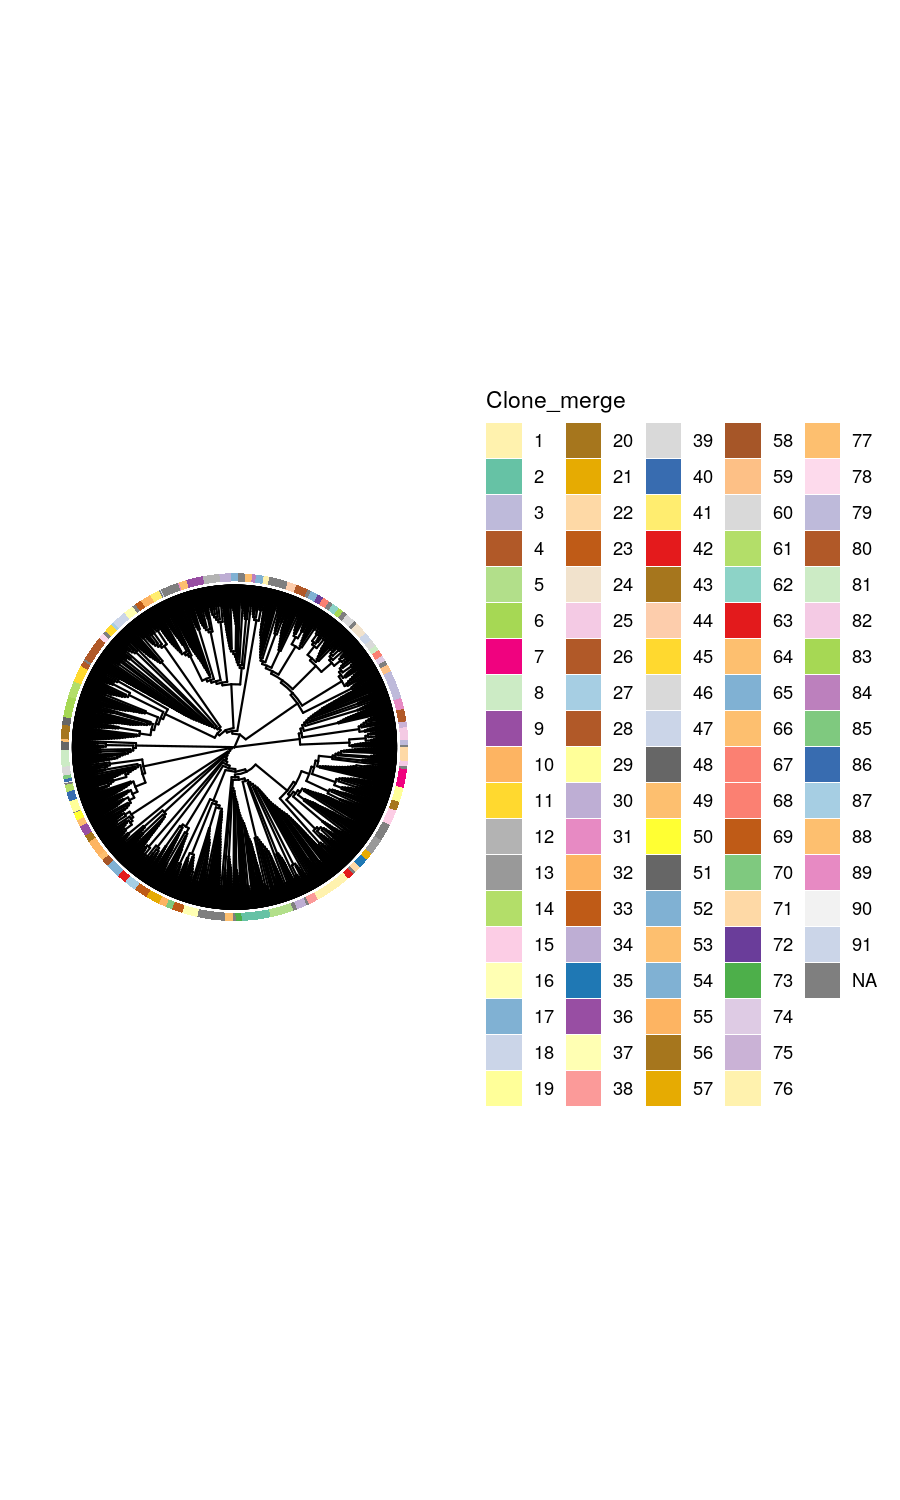

In [52]:
#Visulize
library(RColorBrewer)
library(ggtree)
library(ggtreeExtra)
Example_redeemR@CellMeta$Clone_merge<-as.factor(Example_redeemR@CellMeta$Clone_merge)
n=length(unique(Example_redeemR@CellMeta$Clone_merge))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
col_vector<-sample(col_vector,n,replace=T)
options(repr.plot.width=6, repr.plot.height=10,repr.plot.res=150)
p<-ggtree(Example_redeemR@TREE@treedata,layout="circular", branch.length='none') 
p+geom_fruit( 
         data=Example_redeemR@CellMeta, 
         mapping=aes(y=Cell,x=2,fill=Clone_merge), geom=geom_tile,
         pwidth=0.001, 
         width=3, 
         offset=0.05
     )+scale_fill_manual(values=col_vector)

# Link sc-multiome(GEX+ATAC) data<a name='S11' />